In [ ]:
import torch
from torch import nn
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms

import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["font.size"] = 16

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BATCH_SIZE = 512
LR = 1E-3
WD = 1E-2

## Dataset - MNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform)

## Model

In [ ]:
# Lenet 300-100 architecture
class Model(nn.Module):
    def __init__(self, n_labels=10):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, n_labels)
        )
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.layers(x)
        return x

In [ ]:
# Reference - https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [ ]:
# Reference - https://github.com/rahulvigneswaran/Lottery-Ticket-Hypothesis-in-Pytorch/blob/master/main.py
# Training loop
def train(model, train_loader, optimizer, criterion):
    EPS = 1e-6
    model.train()
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()

        # Freezing pruned weights by making their gradients zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).to(device)
        optimizer.step()
    return train_loss.item()

# Testing loop
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    log_softmax = nn.LogSoftmax(dim=1)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()
            pred = log_softmax(output.data).max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

## Utility functions

In [ ]:
# Print number of non-zero weights in each layer and return overall non-zero weights count
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

In [ ]:
# Get the initial mask for the model weights (bias terms to be ignored)
def get_model_mask(model):
    mask = []
    for name, param in model.named_parameters(): 
        if 'weight' in name:
            curr_mask = torch.ones_like(param.data)
            mask.append(curr_mask)
    return mask

In [ ]:
# Get mask which will remove (zero-out) weights with value less than p-th percentile (layer-wise)
def mask_for_prune_by_percentile(model, mask, p):
    cntr = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_values = param.data.cpu().numpy()
            weight_values_nonzero = weight_values[np.nonzero(weight_values)]
            percentile_value = np.percentile(np.abs(weight_values_nonzero), p)
            
            new_mask = torch.where(torch.abs(param.data) < percentile_value, torch.zeros_like(mask[cntr]), mask[cntr])

            # Assign new mask
            mask[cntr] = new_mask
            cntr += 1

    return mask

In [ ]:
# Run training for n pruning iterations for e epochs and get statistics
def get_statistics(config, mask, model, initial_weights, optimizer, criterion, train_dataloader, test_dataloader):
    all_best_accuracies = []
    all_non_zero_weights_perc = []
    all_loss_values = []
    all_accuracy_values = []

    for iteration_step in range(config["PRUNING_ITERATIONS"]):
        if iteration_step > 0:
            mask = mask_for_prune_by_percentile(model, mask, config["PRUNE_PERCENT"])

            if config["PRUNING_STRATEGY"] == "random-reinitialization":
                model.apply(weight_init)

                cntr = 0
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        param.data = param.data * mask[cntr]
                        cntr = cntr + 1
            else:
                cntr = 0
                for name, param in model.named_parameters(): 
                    if "weight" in name: 
                        param.data = initial_weights[name] * mask[cntr]
                        cntr = cntr + 1
                    if "bias" in name:
                        param.data = initial_weights[name]

            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

        loss_values = []
        accuracy_values = []
        best_accuracy = 0

        print(f"Pruning Step: {iteration_step}")
        nonzero_weights_perc = print_nonzeros(model)

        for epoch in tqdm(range(config["NUM_EPOCHS"])):
            loss = train(model, train_dataloader, optimizer, criterion)
            loss_values.append(loss)
            accuracy = test(model, test_dataloader, criterion)
            accuracy_values.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy

        all_best_accuracies.append(best_accuracy)
        all_non_zero_weights_perc.append(nonzero_weights_perc)
        all_loss_values.append(loss_values)
        all_accuracy_values.append(accuracy_values)

    return all_best_accuracies, all_non_zero_weights_perc, all_loss_values, all_accuracy_values

## Start training and gather statistics

In [ ]:
# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define model
model_lt = Model().to(device)
# Initialization of weights
model_lt.apply(weight_init)
# Copy initial weights
initial_weights = copy.deepcopy(model_lt.state_dict())

optimizer_lt = torch.optim.Adam(model_lt.parameters(), lr=LR, weight_decay=WD)
criterion_lt = nn.CrossEntropyLoss()

# Define mask
mask_lt = get_model_mask(model_lt)

config_lt = {
    "PRUNING_ITERATIONS": 5,
    "NUM_EPOCHS": 5,
    "PRUNE_PERCENT": 50,
    "PRUNING_STRATEGY": "iterative-pruning"
}

all_best_accuracies_lt, all_non_zero_weights_perc_lt, all_loss_values_lt, all_accuracy_values_lt = \
        get_statistics(config_lt, mask_lt, model_lt, initial_weights, optimizer_lt, criterion_lt, train_dataloader, test_dataloader)

Pruning Step: 0
layers.0.weight      | nonzeros =  235200 /  235200 (100.00%) | total_pruned =       0 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =    1000 /    1000 (100.00%) | total_pruned =       0 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 266610, pruned : 0, total: 266610, Compression rate :       1.00x  (  0.00% pruned)


100%|██████████| 5/5 [01:06<00:00, 13.39s/it]


Pruning Step: 1
layers.0.weight      | nonzeros =  117600 /  235200 ( 50.00%) | total_pruned =  117600 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =   15000 /   30000 ( 50.00%) | total_pruned =   15000 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =     500 /    1000 ( 50.00%) | total_pruned =     500 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 133510, pruned : 133100, total: 266610, Compression rate :       2.00x  ( 49.92% pruned)


100%|██████████| 5/5 [01:00<00:00, 12.09s/it]


Pruning Step: 2
layers.0.weight      | nonzeros =   58800 /  235200 ( 25.00%) | total_pruned =  176400 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =    7500 /   30000 ( 25.00%) | total_pruned =   22500 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =     250 /    1000 ( 25.00%) | total_pruned =     750 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 66960, pruned : 199650, total: 266610, Compression rate :       3.98x  ( 74.88% pruned)


100%|██████████| 5/5 [01:00<00:00, 12.06s/it]


Pruning Step: 3
layers.0.weight      | nonzeros =   29400 /  235200 ( 12.50%) | total_pruned =  205800 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =    3750 /   30000 ( 12.50%) | total_pruned =   26250 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =     125 /    1000 ( 12.50%) | total_pruned =     875 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 33685, pruned : 232925, total: 266610, Compression rate :       7.91x  ( 87.37% pruned)


100%|██████████| 5/5 [01:02<00:00, 12.42s/it]


Pruning Step: 4
layers.0.weight      | nonzeros =   14700 /  235200 (  6.25%) | total_pruned =  220500 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =    1875 /   30000 (  6.25%) | total_pruned =   28125 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =      63 /    1000 (  6.30%) | total_pruned =     937 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 17048, pruned : 249562, total: 266610, Compression rate :      15.64x  ( 93.61% pruned)


100%|██████████| 5/5 [01:00<00:00, 12.12s/it]


In [ ]:
# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define model
model_reinit = Model().to(device)
# Initialization of weights
model_reinit.load_state_dict(initial_weights)

optimizer_reinit = torch.optim.Adam(model_reinit.parameters(), lr=LR, weight_decay=WD)
criterion_reinit = nn.CrossEntropyLoss()

# Define mask
mask_reinit = get_model_mask(model_reinit)

config_reinit = {
    "PRUNING_ITERATIONS": 5,
    "NUM_EPOCHS": 5,
    "PRUNE_PERCENT": 50,
    "PRUNING_STRATEGY": "random-reinitialization"
}

all_best_accuracies_reinit, all_non_zero_weights_perc_reinit, all_loss_values_reinit, all_accuracy_values_reinit = \
        get_statistics(config_reinit, mask_reinit, model_reinit, initial_weights, optimizer_reinit, criterion_reinit, train_dataloader, test_dataloader)

Pruning Step: 0
layers.0.weight      | nonzeros =  235200 /  235200 (100.00%) | total_pruned =       0 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =    1000 /    1000 (100.00%) | total_pruned =       0 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 266610, pruned : 0, total: 266610, Compression rate :       1.00x  (  0.00% pruned)


100%|██████████| 5/5 [01:00<00:00, 12.14s/it]


Pruning Step: 1
layers.0.weight      | nonzeros =  117600 /  235200 ( 50.00%) | total_pruned =  117600 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =   15000 /   30000 ( 50.00%) | total_pruned =   15000 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =     500 /    1000 ( 50.00%) | total_pruned =     500 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 133510, pruned : 133100, total: 266610, Compression rate :       2.00x  ( 49.92% pruned)


100%|██████████| 5/5 [00:59<00:00, 11.97s/it]


Pruning Step: 2
layers.0.weight      | nonzeros =   58800 /  235200 ( 25.00%) | total_pruned =  176400 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =    7500 /   30000 ( 25.00%) | total_pruned =   22500 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =     250 /    1000 ( 25.00%) | total_pruned =     750 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 66960, pruned : 199650, total: 266610, Compression rate :       3.98x  ( 74.88% pruned)


100%|██████████| 5/5 [01:01<00:00, 12.21s/it]


Pruning Step: 3
layers.0.weight      | nonzeros =   29400 /  235200 ( 12.50%) | total_pruned =  205800 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =    3750 /   30000 ( 12.50%) | total_pruned =   26250 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =     125 /    1000 ( 12.50%) | total_pruned =     875 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 33685, pruned : 232925, total: 266610, Compression rate :       7.91x  ( 87.37% pruned)


100%|██████████| 5/5 [00:59<00:00, 11.98s/it]


Pruning Step: 4
layers.0.weight      | nonzeros =   14700 /  235200 (  6.25%) | total_pruned =  220500 | shape = (300, 784)
layers.0.bias        | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (300,)
layers.2.weight      | nonzeros =    1875 /   30000 (  6.25%) | total_pruned =   28125 | shape = (100, 300)
layers.2.bias        | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
layers.4.weight      | nonzeros =      63 /    1000 (  6.30%) | total_pruned =     937 | shape = (10, 100)
layers.4.bias        | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 17048, pruned : 249562, total: 266610, Compression rate :      15.64x  ( 93.61% pruned)


100%|██████████| 5/5 [00:59<00:00, 11.92s/it]


In [ ]:
all_best_accuracies_lt

[92.13, 92.05, 92.06, 91.87, 91.3]

In [ ]:
all_best_accuracies_reinit

[91.93, 91.18, 90.19, 89.15, 61.27]

In [ ]:
all_accuracy_values_lt

[[88.5, 91.23, 91.83, 91.38, 92.13],
 [91.21, 91.4, 92.04, 92.05, 91.97],
 [91.17, 91.45, 91.47, 92.06, 91.85],
 [90.81, 91.46, 91.48, 91.3, 91.87],
 [90.2, 90.71, 91.1, 91.3, 91.16]]

In [ ]:
all_accuracy_values_reinit

[[90.29, 91.39, 91.93, 91.7, 91.58],
 [89.58, 89.82, 90.61, 90.95, 91.18],
 [86.97, 88.81, 89.8, 90.13, 90.19],
 [70.0, 86.19, 87.93, 88.73, 89.15],
 [28.18, 47.17, 57.17, 60.62, 61.27]]

## Experiment plots

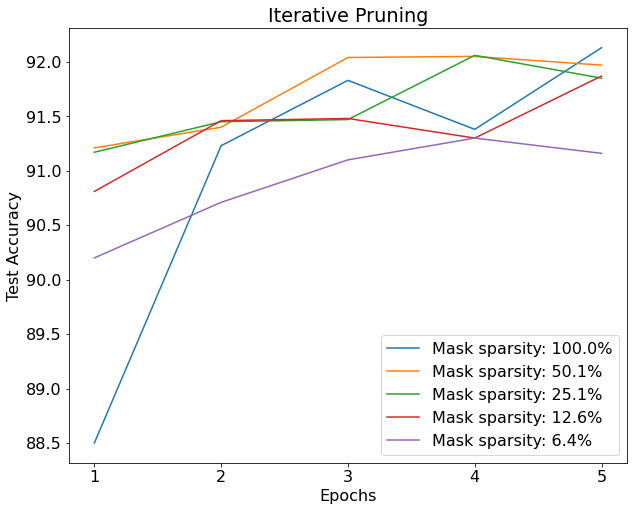

In [ ]:
# Plot for Winning Tickets - Iterative Pruning
sparsity = [str(x) + "%" for x in all_non_zero_weights_perc_lt]

fig0, ax0 = plt.subplots(1, 1)
for i in range(len(all_accuracy_values_lt)):
     ax0.plot(range(1, config_lt['NUM_EPOCHS']+1), all_accuracy_values_lt[i], label="Mask sparsity: " + sparsity[i])

ax0.set_xlabel('Epochs')
ax0.set_ylabel('Test Accuracy')
ax0.set_title('Iterative Pruning')
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.legend();

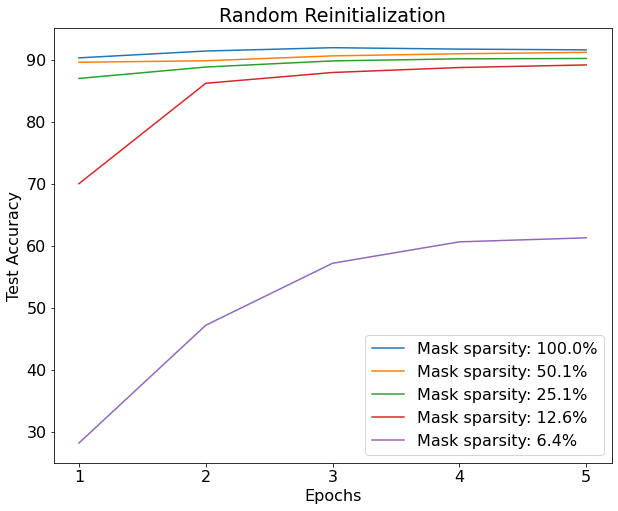

In [ ]:
# Plot for Winning Tickets - Random Reinitialization
sparsity = [str(x) + "%" for x in all_non_zero_weights_perc_reinit]

fig0, ax0 = plt.subplots(1, 1)
for i in range(len(all_accuracy_values_reinit)):
     ax0.plot(range(1, config_reinit['NUM_EPOCHS']+1), all_accuracy_values_reinit[i], label="Mask sparsity: " + sparsity[i])

ax0.set_xlabel('Epochs')
ax0.set_ylabel('Test Accuracy')
ax0.set_title('Random Reinitialization')
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.legend();

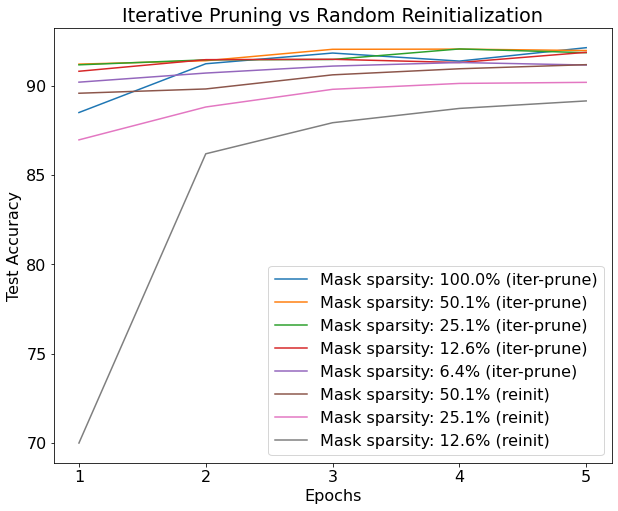

In [ ]:
# Plot for Winning Tickets - Both
vals = all_accuracy_values_lt + all_accuracy_values_reinit[1:4]

non_zero_percs_lt = all_non_zero_weights_perc_lt
sparsity_lt = [str(x) + "% (iter-prune)" for x in non_zero_percs_lt]

non_zero_percs_reinit = all_non_zero_weights_perc_reinit[1:4]
sparsity_reinit = [str(x) + "% (reinit)" for x in non_zero_percs_reinit]

sparsity = sparsity_lt + sparsity_reinit

fig0, ax0 = plt.subplots(1, 1)
for i in range(len(vals)):
     ax0.plot(range(1, config_lt['NUM_EPOCHS']+1), vals[i], label="Mask sparsity: " + sparsity[i])

ax0.set_xlabel('Epochs')
ax0.set_ylabel('Test Accuracy')
ax0.set_title('Iterative Pruning vs Random Reinitialization')
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.legend();

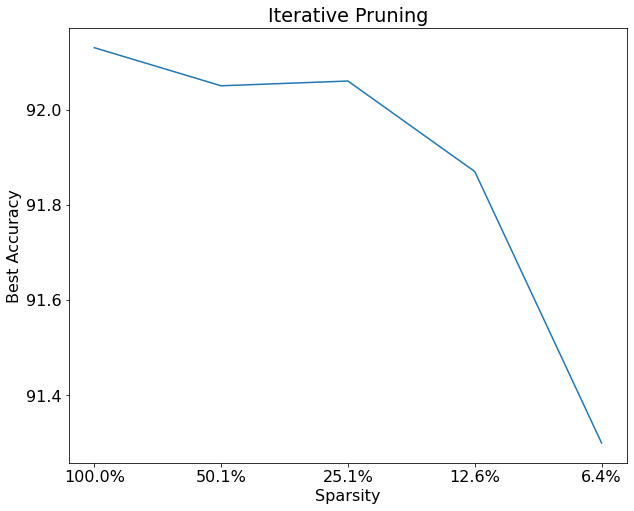

In [ ]:
# Plot for best accuracy of Winning Tickets - Iterative Pruning
sparsity = [str(x) + "%" for x in all_non_zero_weights_perc_lt]

fig0, ax0 = plt.subplots(1, 1)
tickvals = range(1, config_lt['PRUNING_ITERATIONS']+1)
ax0.plot(tickvals, all_best_accuracies_lt)
ax0.set_xlabel('Sparsity')
ax0.set_ylabel('Best Accuracy')
ax0.set_title('Iterative Pruning')
ax0.set_xticks(tickvals)
ax0.set_xticklabels(sparsity);

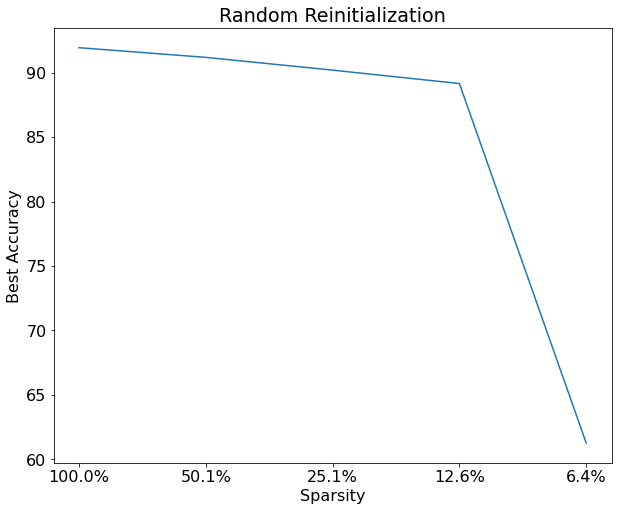

In [ ]:
# Plot for best accuracy of Winning Tickets - Random Reinitialization
sparsity = [str(x) + "%" for x in all_non_zero_weights_perc_reinit]

fig0, ax0 = plt.subplots(1, 1)
tickvals = range(1, config_reinit['PRUNING_ITERATIONS']+1)
ax0.plot(tickvals, all_best_accuracies_reinit)
ax0.set_xlabel('Sparsity')
ax0.set_ylabel('Best Accuracy')
ax0.set_title('Random Reinitialization')
ax0.set_xticks(tickvals)
ax0.set_xticklabels(sparsity);